### 1. 问题描述
本次作业中，将选择2个数据集进行分析与挖掘

### 2.可选数据集
来源包括：

* SNAP(Stanford Large Network Dataset Collection): http://snap.stanford.edu/data/index.html
* Microsoft 资讯推荐:  https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets
* YELP: https://www.yelp.com/dataset/download
* DBLP: https://dblp.uni-trier.de/xml/

### 3. 数据分析要求
数据获取与预处理；

频繁模式挖掘：可以是项集、序列和图。

模式命名：如论文-作者网络中合作模式、引用模式和发表模式等，不同的领域的频繁模式的含义也不尽相同，需自行确定模式的名称。

对挖掘结果进行分析；

可视化展示。

### 4. 提交的内容
数据集获取和预处理的代码

关联规则挖掘的代码

挖掘过程的报告：展示挖掘的过程、结果和你的分析

所选择的数据集在README中说明，数据文件不要上传到Github中

乐学平台提交注意事项：

仓库地址：记得加上 

报告：附件，word，pdf，html格式都可以

## 数据集 Microsoft 资讯推荐

数据集获取和预处理

In [2]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip' # 训练集
validation_small_url = f'{base_url}/MINDsmall_dev.zip' # 验证集
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [3]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None

    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [4]:
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

['behaviors.tsv',
 'news.tsv',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'entity_embedding.vec',
 'relation_embedding.vec']

In [5]:
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
df

,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...
...,...,...,...,...,...
73147,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...
73148,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...
73149,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...
73150,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...


In [6]:
news_path = os.path.join(temp_dir, 'news.tsv')
pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
42411,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[]
42412,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida..."
42413,N30135,news,newsgoodnews,Tennessee judge holds lawyer's baby as he swea...,Tennessee Court of Appeals Judge Richard Dinki...,https://assets.msn.com/labs/mind/BBWyzI8.html,"[{""Label"": ""Tennessee"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Tennessee Court of Appeals"", ""Type..."
42414,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [7]:
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,
                                     'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q34433,"[0.017808, -0.073256, 0.102521, -0.059926, -0...."
1,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
2,Q56037,"[0.02155, -0.044888, -0.027872, -0.128843, 0.0..."
3,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
4,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
...,...,...
22888,Q278846,"[0.042413, 0.021957, 0.072414, -0.068437, 0.02..."
22889,Q54621949,"[-0.018299, -0.048378, -0.021645, -0.079743, 0..."
22890,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
22891,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [8]:
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,
                                                       1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector'
                                         ]].rename(columns={0: "relation"})
relation_embedding

,relation,vector
0,P31,"[-0.073467, -0.132227, 0.034173, -0.032769, 0...."
1,P21,"[-0.078436, 0.108589, -0.049429, -0.131355, 0...."
2,P106,"[-0.052137, 0.052444, -0.019886, -0.152309, 0...."
3,P735,"[-0.051398, 0.056219, 0.068029, -0.137717, -0...."
4,P108,"[0.091231, 0.022526, 0.059349, -0.141853, 0.03..."
...,...,...
1086,P1897,"[-0.019021, 0.001183, -0.009602, -0.040833, -0..."
1087,P3776,"[-0.018365, 0.028526, -0.025934, 0.032296, -0...."
1088,P1194,"[-0.026819, 0.003231, -0.011298, -0.015206, 0...."
1089,P2502,"[0.003554, -0.041121, -0.010559, -0.037862, -0..."


关联规则挖掘

In [9]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 将impressions中的列表转换为矩阵
df['impressions_list'] = df['impressions'].apply(lambda x:x.split(' '))
te = TransactionEncoder()
te_ary = te.fit(df['impressions_list']).transform(df['impressions_list'])
df_matrix = pd.DataFrame(te_ary,columns = te.columns_)

# 使用Apriori算法查找频繁项集
frequent_itemsets = apriori(df_matrix,min_support = 0.2,use_colnames = True)
print("频繁项集：")
print(frequent_itemsets)

# 生成关联规则
rules = association_rules(frequent_itemsets,metric='confidence',min_threshold=0.5)
print("关联规则：")
print(rules)

频繁项集：
      support                                 itemsets
0    0.441328                               (N11930-0)
1    0.286308                               (N13408-0)
2    0.340346                               (N19990-0)
3    0.414548                               (N20036-0)
4    0.245885                               (N23513-0)
..        ...                                      ...
180  0.215989             (N58098-0, N5940-0, N6916-0)
181  0.210179   (N5940-0, N11930-0, N31958-0, N6916-0)
182  0.203221  (N20036-0, N36779-0, N5940-0, N30290-0)
183  0.204615  (N36779-0, N5940-0, N31958-0, N30290-0)
184  0.201006   (N36779-0, N5940-0, N6916-0, N30290-0)

[185 rows x 2 columns]
关联规则：
              antecedents           consequents  antecedent support  \
0              (N19990-0)            (N11930-0)            0.340346   
1              (N11930-0)            (N30290-0)            0.441328   
2              (N30290-0)            (N11930-0)            0.410214   
3              (N119

频繁项集分析：
从频繁项集的支持度来看，（N11903-0）的支持度最高，为0.441328，这表明它是数据集中最常出现的项。其他高项集也意味着在数据集中较为常见。
关联规则分析：
在关联规则中，(N19990-0) -> (N11930-0) 的置信度最高，达到 0.645660，这意味着当 (N19990-0) 出现时，有 64.6% 的概率 (N11930-0) 也会出现，可能表明这两个项之间有一定的联系。
在提升度中，(N30290-0, N5940-0) -> (N6916-0, N36779-0) 的提升度最高，达到 2.418780，这意味着这两个项集中之间存在显著的正相关。
高置信度和高支持度：置信度和支持度较高的规则通常更具意义，像 (N6916-0, N36779-0) -> (N30290-0, N5940-0) 置信度高达 0.792968，提升度也很高，暗示了数据中较为显著的模式。

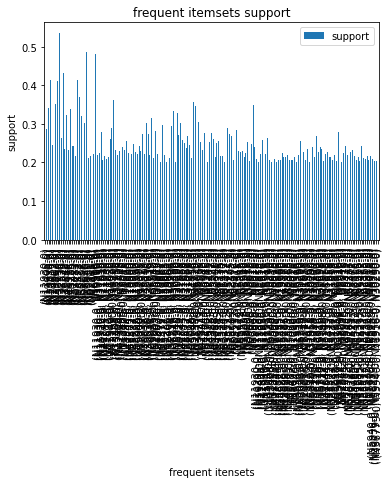

In [10]:
frequent_itemsets.plot(kind='bar',x = 'itemsets',y = 'support')
plt.title('frequent itemsets support')
plt.xlabel('frequent itensets')
plt.ylabel('support')
plt.show()

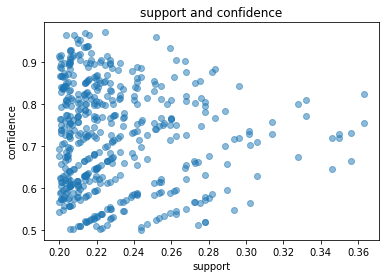

In [11]:
# 使用散点图展示支持度和置信度的关系
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.title('support and confidence')
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()


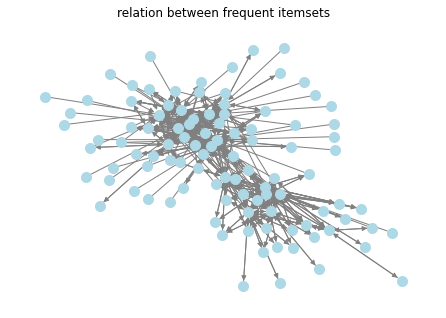

In [12]:
# 创建一个网络图
G = nx.DiGraph()

# 根据关联规则添加边
for _, rule in rules.iterrows():
    G.add_edge(frozenset(rule['antecedents']), frozenset(rule['consequents']), weight=rule['confidence'])

# 绘制网络图
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, font_size=5, node_size=100, edge_color='gray', node_color='lightblue')
plt.title('relation between frequent itemsets')
plt.show()


## 数据集：SNAP(Stanford Large Network Dataset Collection)
Astro Physics collaboration network

In [13]:
# 读取数据，指定制表符作为分隔符
df1 = pd.read_csv('CA-AstroPh.txt', sep='\t', header=None, names=['FromNodeId', 'ToNodeId'])

# 打印数据
print(df1.head())  # 查看前5行数据

# Directed graph (each unordered pair of nodes is saved once): CA-AstroPh.txt 
# Collaboration network of Arxiv Astro Physics category (there is an edge if authors coauthored at least one paper)
# Nodes: 18772 Edges: 396160
# FromNodeId	ToNodeId

   FromNodeId  ToNodeId
0       84424       276
1       84424      1662
2       84424      5089
3       84424      6058
4       84424      6229


In [14]:
# 创建一个有向图
G1 = nx.DiGraph()

# 添加边
edges = list(zip(df1['FromNodeId'], df1['ToNodeId']))  # 将数据转换为边的列表
G1.add_edges_from(edges)

# 检查图的基本信息
print("Number of nodes:", G1.number_of_nodes())
print("Number of edges:", G1.number_of_edges())


Number of nodes: 18772
Number of edges: 396160


In [42]:
strong_components = list(nx.strongly_connected_components(G1))
# print("强连通分量：", strong_components)
node_degrees = {node: G1.degree(node) for node in G1.nodes}
top_n = 10
print("前 {} 个节点的度：".format(top_n))
for node, degree in sorted_node_degrees[:top_n]:
    print(f"节点 {node} 的度：{degree}")
# betweenness_centrality = nx.betweenness_centrality(G1)
# print("介数中心性：", betweenness_centrality)

前 10 个节点的度：
节点 53213 的度：1008
节点 35290 的度：854
节点 38109 的度：840
节点 62821 的度：836
节点 93504 的度：774
节点 92790 的度：768
节点 21718 的度：738
节点 1086 的度：724
节点 89732 的度：702
节点 111161 的度：700
